<center>
    <h1> Study of the Covid-19 Vaccine Acceptance</h1>
    <h4> BDA Fall 2020 - Final Project </h4>
    <hr>
    <br><br>
    <h3>Rafel Palliser & Albert Rial</h3>
    <br><br>
</center>

## 1. Problem description

The goal of this study is to analyze the acceptance of the Covid-19 Vaccine by examinating tweets referring to it. We truly think this is an important study because Covid-19 has drastically changed our lives, and its vaccine could change them again.

The followed pipeline starts by gathering the data throughout the Twitter API and storing it into a MongoDB. Once done, we perform a first data exploration to study the different fields contained in a tweet, and if there are missing values in the fields we need for our analysis. Afterwards, the data is processed and cleaned in order to be completely prepared for the study of the vaccine acceptance.

ALGO MAS?!?

Introducció:
- Storytelling
- (Done) Com fer la query? Quina? (volíem dades al llarg de molt temps, no d'un instant concret)
- (Done) covid té hashtag, vacuna no --> triar idiomes --> query #covid 24h ......

Data Exploration:
- (Done) Estudi de fields
- (Done) Quants són rt, originals, ..?
- (Done) Estudi de missing values i com estan codificats dels que ens afecten (text, geo)
- (Done) Distribució idiomes
- (Done) Explicar GEO!!!
- Llista / Mapa d'on estan els tweets
- Evolució del nb de tweets al llarg del temps (histograma..) (incloure notícies)
- Llista de top hashtags
- Llista top words (exclude stopwords,...)?

Estudi. Study on the acceptance of covid-19 vaccine:
- Mapa / Dist d'on es parla més de cada vacuna (mirar la distribució de la vacuna que es parla més segons el país)
- Evolució del sentiment al llarg del temps (relació amb notícies)
- Evolució del sentiment al llarg del temps de cada vacuna
- Sentiment segons pais. Mapa global de pro-vaccine i anti-vaccine
- Sentiment segons pais i vacuna?

Hagués estat bé tenir edat/sexe per fer estudi sociologic però no el tenim.

## 2. Data gathering and storage

Data gathering is one of the most important parts of a data project or analysis, although it may not seem so. Sometimes the researcher cannot control this part because others gathered the data, and have to face other more complicated problems to process it and extract valuable information. In this project, we have the opportunity to design the data gathering process, and that's why we have spend much time on it.

The constraints on our data gathering process come from the theme of this project, Covid-19 Vaccine Acceptance, and the source we have decided to use, Twitter. Knowing that one of the key interaction factors of this social network are the use of hashtags, we noticed the fact that the Covid-19 Vaccine has not a hashtag associated to it, or at least not a global one in a similar way that Covid-19 has #Covid, #Covid19 or #Covid-19.

Also, the word vaccine is written in different ways depending on the language, so in order to not introduce a large bias on languages due to our query, we made a preliminar study of the most used languages in tweets talking about Covid-19. Trying to be as fair as possible, we collected tweets for exactly 24h (to not discriminate any time zone) containing one of the mentioned hashtags associated with Covid-19. We are aware that countries using a non-latin alphabet may refer to the virus in a different way, but we don't aim to obtain tweets in those languages as we won't be able to process the tweet text in our analysis. Taking this into account, we obtained the following results:

In [38]:
# -*- coding: utf-8 -*-
import pymongo
from src.keys import MONGODB_KEY
from bson.son import SON

# Set up a connection to our remote db
client = pymongo.MongoClient('fpsds.synology.me', 27017, username='mongoadmin', password=MONGODB_KEY)
db = client['tweets']
tweets = db['covid_hashtags_24h']

<a id='lang_study'></a>

In [2]:
# Group by language, and compute the count of tweets belonging to each
pipeline = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 10}
]
tot = tweets.count_documents({})
res = tweets.aggregate(pipeline)
acc = 0
langs = []
counts = []
print('Lang         %       Acc %')
for lang in res:
    langs.append(lang['_id'])
    counts.append(lang['count'])
    acc += lang['count']
    print('{:4s}    {:5.2f}%      {:5.2f}%'.format(lang['_id'], 100*lang['count']/tot, 100*acc/tot))

Lang         %       Acc %
en      61.58%      61.58%
es      17.08%      78.66%
fr       5.11%      83.77%
it       2.87%      86.63%
und      2.26%      88.90%
de       1.98%      90.88%
in       1.42%      92.30%
hi       1.22%      93.52%
ja       0.95%      94.47%
pt       0.93%      95.41%


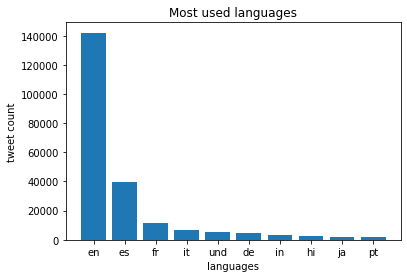

In [3]:
from src.plots import barplot
barplot(langs, counts, 'Most used languages', 'languages', 'tweet count')

Note that more than 60% of tweets are written in English, and another 17% in Spanish. The following most used language is French, which appears in 5% of the tweets, and the subsequent languages are only used in less than 3% of tweets. Looking at the histogram, it seems that the most logical choice would be to only look for tweets written in English. However, as these only cover the 60% of the gathered ones, we decided to also look after the Spanish ones, thus increasing our coverage to almost 80%.

Note that this is an approximation, assuming the tweets talking about the Covid-19 vaccine follow the same language distribution that the ones talking about Covid-19 generally.

### The actual data gathering process

The [Twitter API](https://developer.twitter.com/en) provides two main ways of gathering tweets. On one side we have the streaming option, which gets the tweets matching a certain query in real time. On the other, we have the option of dowloading indexed tweets from their database, from which one can download data from the 7-10 prior days with a free developer account.

After testing both options, we decided to go for the second one, as we could make queries every 7 days and obtain the tweets for the whole period without having to leave a computer running a script 24/7, much more time. Also, we predicted (now confirmed) that during December the vaccine topic would become more and more trendy, so we wanted to download tweets for a long period of time.

[src/collect_tweets.py](src/collect_tweets.py) is the script we have been using to download tweets and insert them in a database. We decided to not include the code in this notebook but leave it in a separate file because we run it asynchronously. In the file, one can see we have used [Tweepy](https://www.tweepy.org/) (a python library wrapping the Twitter API) and the actual parameters we have used to gather tweets. Apart from 'since', 'until' and 'max_id', which serve to control the period of time from we desire to download tweets; there is 'lang', which we set to 'None' (working as 'any') as the API does not accept a list of languages; and the most important one, the query itself: **'#covid OR #covid19 vaccine OR vacuna'**.

In the [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/guides/standard-operators) it can be easily seen that the 'OR' operator works as a logical OR betweet the two contiguous terms, and a simple whitespace works as an AND. Therefore, we are looking for tweets that contain (#covid or #covid19) and (vaccine or vacuna). The first part is to ensure the resulting tweets refer to the Covid-19 vaccine (note that #covid also matches #covid-19, so we are covering all the three most-used global hashtags for Covid-19). The second part is to ensure that the tweets specifically refer to the vaccine, and we include the word in English and Spanish as we decided in the previous language study because there is not a unified term to refer to the vaccine globaly. Note that we search for the word and not the hashtag, because although local hashtags #vaccine or #vacuna exists, few people use them. Also note that the way the Twitter search work, our query 'vaccine' also matches a possible hashtag '#vaccine', so we are not losing these results.

We have been running this script from November, 29 to December, 29 collecting a total amount of 872828 tweets for a whole month, which have been stored into a MongoDB database.

### Storage

Relational databases are a efficient solution for storage, but require strictly structured data, which does not directly match with tweets, which come in a json format and with several different fields depending on the type of tweet. For this reason, we have decided to use a NoSQL database. Specificaly we have chosen [MongoDB](https://www.mongodb.com/es), which is document oriented and matches the data type perfectly (json-like objects). The fact that we already know its language and it has a Python library ([PyMongo](https://pypi.org/project/pymongo/)) ready to use also played a role in our decision.

For this project, we set up a MongoDB server using [Docker](https://www.docker.com/), and left it running in a machine which is visible in the public network, so we are able to work from home with an online, up-to-date and synchronized database, which is always available.

## 3. Data Description

<a id='first_look'></a>
### 3.1. First look at our data

In this section we are going to present our data, explain the different fields it contains and the ones that will be important for our future analysis.

In [33]:
# Get the collection that contains all the tweets for our query
tweets = db['#covid_vaccine']

In [34]:
# Check the number of tweets in the database
n_tweets = tweets.count_documents({})
print('The total amount of tweets in the database is {}'.format(n_tweets))

The total amount of tweets in the database is 872828


In [6]:
# Check the size of the collection (note that this is approximate and includes data and indexes)
print('Collection size = {:.2f}GB'.format(db.command("collstats", "#covid_vaccine")['size']/1e9))

Collection size = 5.31GB


Each collected tweet document has many fields, and printing a complete one would take much space of this report. For this reason, let's first take a look to all the possible primary fields (not nested ones) a tweet can have:

In [7]:
%%time

# Just for exposition, let's try this the 'wrong' way

key_set = set()
for tweet in tweets.find({}):
    tweet_keys = tweet.keys()
    key_set = key_set.union(tweet_keys)
print(sorted(list(key_set)))

['_id', 'contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'full_text', 'geo', 'hashtag_acceptance', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'my_geo', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text_sentiment', 'truncated', 'user', 'withheld_in_countries']
Wall time: 38min 28s


Note how retrieving all documents to perform computations locally is a really bad idea, not only for the memory usage (in this case it is not huge as we are processing one tweet at a time), but mainly in efficiency. It took ALMOST 40 minutes, which makes sense as we are moving approximately 5GB of data through the network. In fact, using the network is what makes it slow, as executing this exact cell in localhost takes approximately 3 minutes. 

However, we have to take in mind that in a real-life setup we most likely couldn't execute these scripts in the same exact machine that hosts the database server. For this reason, to close the gap with what we are going to face in real problems, we are executing this notebook from outside the server, so presented running times refer to this setup.

The conclusion we can extract is that whenever facing a big data problem, one does not want to move the data, but to perform the computation in the database, which is optimized for doing so, and only return the desired results.

This is exactly what we are doing in the following cell by applying a MapReduce model in the server side:

In [8]:
%%time

# Take advantage of MapReduce, which is executed on the DB side
# Map function: Emit each key. We assign a value 'null' because we are only interested in the keys
# Shuffle: We will have a list of nulls for each different key
# Reduce: Don't look at the list 's', just return 'null' as we don't want any value, only the different keys
# Output: Store the information in a new collection
tweet_keys = tweets.map_reduce("""function() {for (var key in this) {emit(key, null);}}""", 
                  """function(key, s) {return null;}""",
                  "#covid_vaccine_keys")
keys = tweet_keys.find({},{'value': 0})
print([e['_id'] for e in keys])

['_id', 'contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'extended_entities', 'favorite_count', 'favorited', 'full_text', 'geo', 'hashtag_acceptance', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'metadata', 'my_geo', 'place', 'possibly_sensitive', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweet_count', 'retweeted', 'retweeted_status', 'source', 'text_sentiment', 'truncated', 'user', 'withheld_in_countries']
Wall time: 35.1 s


We obtain the same exact result while working 60 times faster! When running this in the server (localhost), it also takes around 30 seconds, which is 6 times faster than the 3 minutes the previous query took using localhost. This proves that, having or not the problem of the network, performing computation at the database is always better. Also, when we only return the results, the problem of moving data through the nework gets incredibly reduced.

Regarding the result, the meaning of all these fields is explained in the [Twitter API website](https://developer.twitter.com/en/docs/twitter-api/premium/data-dictionary/object-model/tweet), but we are going to review the ones that are interesting for our work:
- `_id` is the MongoDB unique id, which we manually set to be the tweet `id`, which is also unique and increases chronologically. It is encoded as an int64 and can also be found string formatted at `id_str`.
- `coordinates` contains the longitude and latitude from where the tweet was sent. `coordinates.coordinates` is a 2-dimensional array. Null if geolocalization is deactivated.
- `created_at` is a string containing the UCT timestamp of the creation of the tweet. Example: "Wed Oct 10 20:19:24 +0000 2018"
- `display_text_range` is an array containing the offsets of the characters that form the real text message. Note that when you reply to a tweet, your own tweet starts with the user mention `@user`, which is not part of your reply text.
- `entities` is an object-like attribute that contains, among others, the detected hashtags `#hashtag` and user mentions `@user` along with their character offsets.
- `full_text` is the most important field, containing the actual text of the tweet.
- `geo` is a deprecated field, now substituted by `coordinates`. Null if geolocalization is deactivated.
- `in_reply_to` family of attributes indicate if a tweet is actually a reply of another one, its id and its author. Null for non-reply tweets.
- `lang` indicates the language of the tweet, detected in a best-effort manner.
- `place` is an object-like field which includes information about the place from which a tweet has been sent (not only coordinates, but also country and sometimes city or even neighbourhood). Null if geolocalization is deactivated.
- `quoted_status` is an attribute only present if the tweet contains a quote to another tweet. The value of this attribute, if present, is another whole tweet object.
- `retweeted_status` is a field which is only present if the tweet is actually a retweet of another original tweet, contained in the attribute.
- `truncated` is a compatibility flag which indicates if a tweet text is truncated to 140 characters. It will be false in all our documents as we enabled 'extended_mode' in our query (see [src/collect_tweets.py](src/collect_tweets.py))
- `user` is a whole object with lots of different fields regarding the author of the tweet. Specifically, `user.location` is interesting because it shows the location the user has set to be visible in its profile. Note that this is a free field, and the user can write anything on it.

Let's see a tweet projecting the attributes we really are interested in:

In [35]:
from pprint import pprint
tweet = tweets.find_one({},{'_id':1, 'coordinates':1, 'created_at':1, 'display_text_range':1, 
                    'entities.hashtags':1, 'full_text':1, 'in_reply_to_status_id':1, 'lang':1, 
                    'place':1, 'quoted_status':1, 'retweeted_status':1, 'user.location':1})
# '_id': 1336317355832602627
pprint(tweet)

{'_id': 1336317355832602627,
 'coordinates': None,
 'created_at': 'Tue Dec 08 14:30:59 +0000 2020',
 'display_text_range': [0, 279],
 'entities': {'hashtags': [{'indices': [53, 64], 'text': 'coverstory'},
                           {'indices': [254, 261], 'text': 'irchat'},
                           {'indices': [262, 270], 'text': 'covid19'},
                           {'indices': [271, 279], 'text': 'vaccine'}]},
 'full_text': 'Covid-19: Big pharma to the rescue | Our winter 2020 '
              '#coverstory looks at what IR is like under the coronavirus '
              'spotlight. We hear from @AstraZeneca, CureVac, @Sentieo and '
              '@MorganStanley on the impact for the sector | IR Magazine '
              'https://t.co/nnpwucYkSi #irchat #covid19 #vaccine',
 'in_reply_to_status_id': None,
 'lang': 'en',
 'place': None,
 'user': {'location': 'Global'}}


From the result, apart from the directly interpretable attributes, we can see that this user has not enabled geolocalization because both `place` and `coordinates` are None. Also, we can see that the location she uses in her profile `user.location` is actually not providing any information about that. Additionally, we can state this is an original tweet, as it is not a retweet nor a quote (as those attributes do not appear).

### 3.2. Study of the different fields

In this section we are going to study the fields that are important for our analysis in more depth.

<a id='types'></a>
#### Tweet "type"

Recognizing the tweet type is important for several reasons.

The first and most important one is to understand the possible interactions in Twitter, and what they imply. A retweet shows agreement with what the original tweet said. However, when quoting, the author can agree or not with the quoted tweet. 

Second, the key information is stored in different fields depending on the tweet type, so identifying it is key for the analysis.

Note that replies (comments to an "original" tweet) will be treated as original tweets themselves, because they don't provide information of the tweet they replied, only the tweet id, which is usually not found in the database.

In [10]:
# Check if replied tweets are in the database
replies = tweets.find({'in_reply_to_status_id': {'$ne': None}}, {'in_reply_to_status_id':1, '_id':0})
list_of_replied_ids = [e['in_reply_to_status_id'] for e in replies]

count = tweets.count_documents({'_id': {'$in': list_of_replied_ids}})
print('Only {} replied tweets are contained in the datbase. This is a {:.2f}% of the number of replies.'.format(count, 100*count/len(list_of_replied_ids)))

Only 2609 replied tweets are contained in the datbase. This is a 12.10% of the number of replies.


As seen in [Section 3.1](#first_look), we can recognize if a tweet object is a retweet by the appearence of the `retweeted_status` attribute. Same with `quoted_status` for quote tweets.

In [11]:
n_retweets = tweets.count_documents({'retweeted_status': {'$exists': True}})
n_quotes = tweets.count_documents({'quoted_status': {'$exists': True}})
n_originals = n_tweets - n_retweets - n_quotes

print('There are {} original tweets, representing a {:.2f}% of the total amount.'.format(n_originals, 100*n_originals/n_tweets))
print('There are {} retweets, representing a {:.2f}% of the total amount.'.format(n_retweets, 100*n_retweets/n_tweets))
print('There are {} quotes, representing a {:.2f}% of the total amount.'.format(n_quotes, 100*n_quotes/n_tweets))

There are 176775 original tweets, representing a 20.25% of the total amount.
There are 674140 retweets, representing a 77.24% of the total amount.
There are 21913 quotes, representing a 2.51% of the total amount.


Note that the vast majority of tweet objects correspond to retweets, then we have a 20% original tweets, and a small amount of quotes.

Now let's see how the tweet text is shown in each of these tweet types. Starting with original ones:

In [12]:
original = tweets.find_one({'retweeted_status': {'$exists': False}, 'quoted_status': {'$exists': False}})
print(original['full_text'])

Covid-19: Big pharma to the rescue | Our winter 2020 #coverstory looks at what IR is like under the coronavirus spotlight. We hear from @AstraZeneca, CureVac, @Sentieo and @MorganStanley on the impact for the sector | IR Magazine https://t.co/nnpwucYkSi #irchat #covid19 #vaccine


Nothing to say about this, `full_text` seems to show the text of the original tweet. Let's move to retweets:

In [13]:
retweet = tweets.find_one({'retweeted_status': {'$exists': True}})
print(retweet['full_text'])

RT @BungerKCBSRadio: Surge. Vaccine. Lockdown.  So many hot #COVID19 topics right now. I'll have @Bob_Wachter with me for #AskAnExpert at 9…


Two things to note here. To begin with, first characters 'RT' indicate it is a retweet. Next ones indicate from whom the retweeted tweet was. Therefore, this characters do not really form part of the text. Second, if we now take a look to `display_text_range`, we can see that the tweet has exactly 140 characters, which is a strange coincidence taking into account that we just saw the text ends in '...':

In [14]:
print(retweet['display_text_range'])

[0, 140]


Looking at the text of the retweeted status:

In [15]:
print(retweet['retweeted_status']['full_text'])

Surge. Vaccine. Lockdown.  So many hot #COVID19 topics right now. I'll have @Bob_Wachter with me for #AskAnExpert at 9:20 AM PST. Send questions to: askus@kcbsradio.com then listen at 9:20 AM on @KCBSRadio @Radiodotcom app &amp; smart speaker (say "Play KCBS Radio") https://t.co/uQsiOzNDpv


Note that looking at the original text we solve both problems. First, we don't have the annoying "RT @user", which we had to remove to process the text; and second, we obtain a text which is no longer cut. Therefore, when we process retweets we will use the `full_text` field of the retweeted status, not the retweet itself. Now let's analyze quotes:

In [16]:
quote = tweets.find_one({'quoted_status': {'$exists': True}})
print(quote['full_text'])
print(quote['display_text_range'])

Dr. #Fauci says that the New York City #firefighters resistance to the vaccine is based on #misinformation just like other people in society who are fearful of the vaccine. #COVID19 https://t.co/Vys5fiNwjV
[0, 181]


It seems to be all right here. Taking into account that the text will make reference to a quoted tweet, when processing quotes we will also take into account the actual quoted text:

In [17]:
print(quote['quoted_status']['full_text'])

Over half of New York City firefighters would refuse COVID-19 vaccine, survey finds. https://t.co/2Dlqb3gDIW


#### Tweet Language

Let's see the distribution of languages in our tweets. We would expect mainly English and Spanish as we have specificaly used the word 'vaccine' in these languages. However, as we could not set the attribute 'lang' in the Twitter API query, we could have some tweets in other languages that used the same words.

In [18]:
# Let's print the top 10 most used languages in tweets referring to Covid-19 vaccine
pipeline = [
    {'$group': {'_id': '$lang', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 10}
]
res = tweets.aggregate(pipeline)
acc = 0
langs = []
counts = []
print('Lang         %       Acc %')
for lang in res:
    langs.append(lang['_id'])
    counts.append(lang['count'])
    acc += lang['count']
    print('{:4s}    {:5.2f}%      {:5.2f}%'.format(lang['_id'], 100*lang['count']/n_tweets, 100*acc/n_tweets))

Lang         %       Acc %
en      73.48%      73.48%
es      21.87%      95.35%
fr       1.31%      96.66%
und      0.85%      97.51%
hi       0.56%      98.07%
ca       0.41%      98.48%
tl       0.17%      98.65%
in       0.17%      98.82%
it       0.15%      98.97%
pt       0.13%      99.10%


This result is completely expected. On one side, there are more than triple the tweets in English than in Spanish, following a quite similar distribution than the one seen in the [previous language study](#lang_study). On the other side, there are some tweets (less than 5%) from other languages, in which they might have included the English word 'vaccine', for example.

As this language attribute is provided in a best-effor manner, in further sections we will analyze it.

#### Geolocalization

Being able to locate from where tweets were sent is an important part for the analysis we aim to perform. For this reason, let's see which information tweets contain.

Let's start by analyzing the field `coordinates`, and `geo` which is its deprecated field:

In [19]:
have_coordinates = tweets.count_documents({'coordinates': {'$ne': None}})
have_geo = tweets.count_documents({'geo': {'$ne': None}})
print('There are {} tweets with coordinates, which corresponds to a {:.2f}%'.format(have_coordinates, 100*have_coordinates/n_tweets))
print('There are {} tweets with geo, which corresponds to a {:.2f}%'.format(have_geo, 100*have_geo/n_tweets))

There are 142 tweets with coordinates, which corresponds to a 0.02%
There are 142 tweets with geo, which corresponds to a 0.02%


Only a tiny part of the data has coordinates associated. Let's check the fact that these 142 tweets are actually the same:

In [20]:
geo_coordinates = tweets.count_documents({'coordinates': {'$ne': None}, 'geo': {'$ne': None}})
print(geo_coordinates)

142


They are actually the same! Let's analyze the `place` field now:

In [21]:
have_place = tweets.count_documents({'place': {'$ne': None}})
print('There are {} tweets with place, which corresponds to a {:.2f}%'.format(have_place, 100*have_place/n_tweets))

There are 5827 tweets with place, which corresponds to a 0.67%


Slightly better, but not that much. Let's check if there is any overlap within tweets containing `place` and `coordinates`.

In [22]:
place_coordinates = tweets.count_documents({'place': {'$ne': None}, 'coordinates': {'$ne': None}})
print(place_coordinates)

142


All tweets with coordinates also have place. Therefore we have a total of 5827 tweets, a 0.67% of all, with geolocalization. This is obviously useless to perform a decent study. For this reason, let's check the field `user.location`, in which each user can write anything, hoping to find valuable information:<a id='list_ul'></a>

In [36]:
pipeline = [
    {'$group': {'_id': '$user.location', 'count': {'$sum': 1}}},
    {"$sort": SON([("count", pymongo.DESCENDING)])},
    {'$limit': 25}
]
res = tweets.aggregate(pipeline)

locations = []
counts = []
print('Count      Location')
for loc in res:
    locations.append(loc['_id'])
    counts.append(loc['count'])
    print('{:6d}     {}'.format(loc['count'], loc['_id']))
locations.append('others')
counts.append(n_tweets - sum(counts))

Count      Location
264872     
  9685     United States
  7606     México
  6368     Washington, DC
  5132     India
  4802     New York, NY
  4633     Canada
  4391     കേരളം
  4335     California, USA
  4179     London, England
  4135     USA
  3525     London
  3451     United Kingdom
  3448     Los Angeles, CA
  3423     Ecuador
  2647     Boston, MA
  2445     Toronto, Ontario
  2442     Chicago, IL
  2303     España
  2243     Florida, USA
  2121     New Delhi, India
  2044     UK
  1911     Ciudad de México
  1864     New York, USA
  1835     Toronto


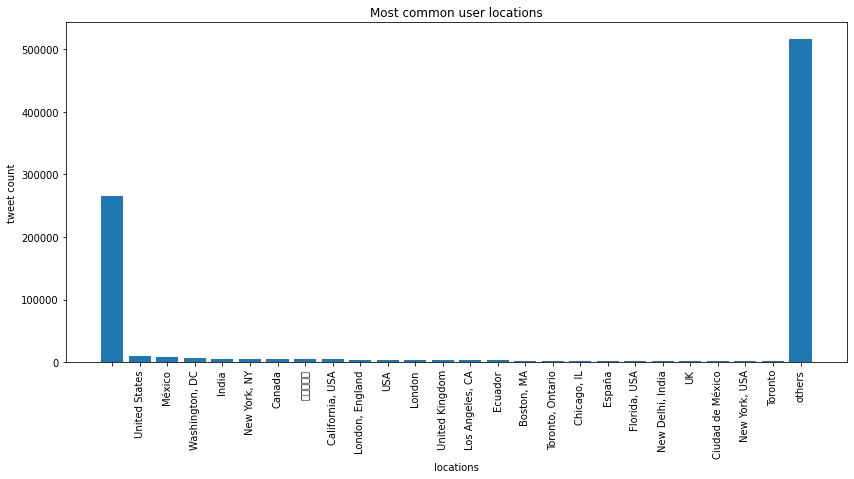

In [39]:
barplot(locations, counts, 'Most common user locations', 'locations', 'tweet count', 90, (14, 8))

The first thing we can see is that 30% of tweets don't contain any information, these users have left the field blank. Furthermore, the non-blank most repeated string is 'United States', but it is included in 'only' 1.1% of the tweets. 'Toronto', which is the top-25 most used location appears in only 0.2% of the tweets. Therefore, the distribution is quite flat over many many different strings (as can be seen in the right-most bar of the plot). Note also that different strings can refer to the same location entity: 'United States' and 'USA', for example.

Therefore, we can conclude that the field `user.location` contains valuable information (the top-25 list shows human-readable known locations), but there is much work to normalize them and obtain value from data.

## 4. Data Preprocessing

In this section we will perform some modifications to our database to adapt it and prepare it for the Covid-19 Vaccine Acceptance analysis.

#### Cleaning

We have noticed that some of our tweets seem to be unavailable due to accounts violating terms and conditions. Let's remove them.

In [30]:
deleted = tweets.delete_many({'full_text': {'$regex': 'account is temporarily unavailable because it violates'}})
print('We have deleted {} tweets'.format(deleted.deleted_count))

We have deleted 5 tweets


Also, from the data exploration we have seen that the field `created_at`, which contains the publication time and date of the tweet is of type string, and starts with the weekday, so there is no way we can sort tweets or group them by day. For this reason, we will create a new field `date` containing the information of the creation date, in a format we can easily sort.

```python
from datetime import datetime

for tweet in tweets.find({}, {'created_at':1}):
    # Parse formatted string
    dt = datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y')
    # Include new field with format YYYY-MM-DD
    tweets.update_one({'_id': tweet['_id']}, {'$set': {'date': dt.strftime('%Y-%m-%d')}})
```

In [7]:
# Print the result for one tweet
pprint(tweets.find_one({}, {'created_at':1, 'date':1, '_id':0}))

{'created_at': 'Tue Dec 08 14:30:59 +0000 2020', 'date': '2020-12-08'}


#### Check language

Twitter announces that their language identification is 'best-effort', which means that it can be not completely accurate. For this reason, before starting processing text and performing a possibly wrong analysis due to the language, we want to check with a language identifier if the results match.

For this section we have used [`langid`](https://github.com/saffsd/langid.py), a standalone Language Identification tool, which works over 97 languages, fast and offline. Furthermore, it uses ISO 639-1 language codes, the exact same norm that Twitter uses.

The code for this analysis is executed offline as it is time consuming, and results are stored in a .pkl serialized file. The source code can be seen in [src/langid.py](src/langid.py), and it is also presented following.

```python
import langid
def get_tweet_text(tweet):
    if 'retweeted_status' in tweet:
        tweet = tweet['retweeted_status']
    return tweet['full_text']

#####
twitter_lang = []
langid_lang = []
for tweet in tweets.find({}, {'full_text':1, 'lang':1, 'retweeted_status.full_text':1}):
    twitter_lang.append(tweet['lang'])
    langid_lang.append(langid.classify(get_tweet_text(tweet))[0])
```

Note that as seen in the [tweet types analysis](#types), we are taking the text from `full_text` for all tweets except retweets, in which we are using `retweeted_status.full_text`.

Let's analyze the results:

In [35]:
import pickle

with open('data/lang_comp.pkl', 'rb') as f:
    langs = pickle.load(f)
langid_lang = langs['langid']
twitter_lang = langs['twitter']

In [67]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(classification_report(langid_lang, twitter_lang, zero_division=0))
print(accuracy_score(langid_lang, twitter_lang))

              precision    recall  f1-score   support

          af       0.00      0.00      0.00        33
          am       1.00      0.01      0.02       601
          an       0.00      0.00      0.00      1506
          ar       0.99      0.45      0.62       821
          as       0.00      0.00      0.00         6
          az       0.00      0.00      0.00        27
          be       0.00      0.00      0.00         1
          bg       0.89      0.73      0.80        11
          bn       0.94      0.86      0.90        93
          br       0.00      0.00      0.00         5
          bs       0.00      0.00      0.00        34
          ca       0.78      0.62      0.69      4493
         ckb       0.00      0.00      0.00         0
          cs       0.68      0.72      0.70        74
          cy       0.00      0.00      0.00        13
          da       0.79      0.89      0.84       342
          de       0.64      0.84      0.73       783
          dv       0.00    

TODO SOME PLOT?
TODO SOME CONCLUSIONS --> Sobretot EN i ES. No utilitzarem langid, twitter és prou fiable.

#### Extracting information from `user.location`

Geolocation data is important for our analysis, but as seen, only few tweets contain a non-null value for `coordinates` or `place`. For this reason we took a look to `user.location`, which although being a free-text field for Twitter users seems to contain valuable information of their locations. In this section we are going to study how to extract information about it.

The first problem we detected in `user.location` was the fact that it is a free-text open field so locations are not normalized. Therefore, a single entity 'United States' could be represented with different strings such as 'USA', 'US', 'United States', 'United States of America', 'Estados Unidos', 'EEUU', ... To solve this problem, we had several options, being the two most viable:
- Create a knowledge base including an array of possible aliases for each entity
- Use a Geocoding API, which are usually able to process different input strings and match them into the same location

Taking into account completeness, resources and time we went for the second option, and tested two different APIs. Firstly, we used Nominatim, which works on OpenStreetMap, it is free but has a 1 query per second limit. On the other side, we tested Google Maps API, which has a 50 query-per-second limit, but it is not free. However, we had some student credit which was enough for our purpose.

After some queries with both APIs we encountered another problem. Although we could normalize places through the API, both were returning a valid location for `user.location` fields that looked like 'CompanyName. IG @company, phone 612-345-6789', which do not contain a location, or 'Planet Earth', 'Everywhere', 'Hotel Room', ... that might be locations but are not valuable for us, as they are not specific/physical ones. If the APIs didn't return anything we would be fine. However, we didn't have a way of discerning the confidence on these responses, so we couldn't differentiate real from 'spurious' locations.

To solve this we tried to, again, create a knowledge base of words usually associated with 'spurious' locations: 'earth', 'planet', 'somewhere', 'room', ... but it was a too simple and greedy way of doing so, and false positives where still there.

After some research we found Carmen [[pdf]](https://www.aaai.org/ocs/index.php/WS/AAAIW13/paper/download/7085/6497%20on%2021%20Nov%202017) [[github]](https://github.com/mdredze/carmen-python), presented by Mark Dredze, Michael J. Paul, Shane Bergsma and Hieu Tran in 2013. Carmen is a project that aims to provide structured location information for tweets gathered through the Twitter API, using geocoding tools and a mix of automatic and manual alias resolution techniques. They process all the fields we are studying in this work, and are well aware of 'spurious' locations and how geocoding APIs try to provide a location for them.

As they explain in their work, they had to create a database of known locations, which included some manual filtering for these 'spurious' locations. Their list of 7040 known locations, which we are using, can be seen at [data/locations.json](data/locations.json). Note that they created a 4-level structure 'Country' > 'State' > 'County' > 'City', and relate locations of different levels by using the 'parent_id'. Let's see an example:

```json
{
    "city": "Compton",
    "uzip": "90220",
    "countrycode": "US",
    "country": "United States",
    "longitude": "-118.224329",
    "countycode": "",
    "county": "Los Angeles County",
    "parent_id": "5244",
    "state": "California",
    "radius": 5700,
    "statecode": "CA",
    "latitude": "33.895285",
    "postal": "",
    "aliases": [
        "Compton, Ca",
        "Compton, California"
    ],
    "id": "2"
  }
```

Note firstly that each location object contains a unique id. Then, we can see that this location is a city one, because the field 'city' appears non-empty. In the database we will find another location with id 5244 (its 'parent_id') that corresponds to the county "Los Angeles County" and will have an empty 'city' field. The same would happen with that location, which will have a parent of type 'state', which again will have a parent of type 'country'. Country locations have 'parent_id': '-1'.

Note also that this location has a latitude and a longitude which correspond to the center of the 'city'; and a radius. Therefore, we have all the geolocation information. Not all locations in the database contain geolocation, but if we keep looking at their ancestors, one of them will always eventually have coordinates. Therefore, we might match with a city, but only have the country coordinates.

Although Carmen is a huge work, aftwer having analyzed the database, we think there are some flaws (duplicates, aliases that make reference other locations, ...) that we have addressed to our convenience. Also, we think their matching algorithm is far from perfect, so we made our own.

[src/clean_carmen_locations.py](src/clean_carmen_locations.py) shows the script we used to clean their database and create ours, which can be seen at [data/cleaned_locations.json](data/cleaned_locations.json) and uses the exact same format.

The idea of this script is to preprocess each original location and extend its aliases list, which will be used to match against `user.location` strings:

- Firstly, we take the original aliases and apply two string normalizations. The first one removes all punctuation signs and lowercases the string. The second one does the same but preserves usual separators converting them into commas. Separators are characters like '()', ',', '/', ... which are usually used to concatenate parts of a location: Barcelona (Spain); Barcelona, Spain; Barcelona|Spain, ... Therefore 'Compton, Ca' would be normalized to 'compton, ca' and to 'compton ca'.
- Second, if the location is a country, add its lowercase contrycode to the aliases
- Third, if the location is a US state, add its lowercase statecode to the aliases
- Fourth, add the lowercased city name if location is a city; county name if it is a county; state name if it is a state or country name if it is a contry.

After having added all these normalized aliases to each location, we perform duplicate detection and processing. If an alias is present in more than one location:
- We priorize concretion. If only one of these locations is a city, assign this alias to the city and remove it from the other locations. If no cities, repeat for counties, states and eventually countries.
- If the alias is present in two locations of the same level, remove it from all locations. We priorize precision over recall and false positives.

Once we have our cleaned database of locations, we use the [src/geotag_tweets.py](src/geotag_tweets.py) script to process tweets and match the best possible location out of our cleaned known locations. The pipeline works as follows:
- From data description we know that there is a certain (small) amount of tweets that contain a `place` field. All places already contain coordinates, but for sake of completness we aim to associate to each tweet a known location from the database. For this reason the first attempt will be to see if the inner fields of `place` match with any known alias. One of them, `place.full_name` contains more specific information. If it does not match, places also contain `place.country` that will most probably match.
    - For `full_name`, we apply the string normalization preserving separators (already explained), so we can easily match with the aliases created in the database. Then we look for structures of the type 'city, state', or 'city, country', in which `full_name` is usually encoded. If we find structures of type 'city, state, country' (more than two entities), these will be taken into account giving priority to the left-most part of the match, which is usually the more concrete entity.
    - For `country`, we look for the lowercased version.
    
- If the tweet does not have a `place` field, we then process `user.location`. We have two options here:
    - If the normalized string (lower case and without punctuation) directly matches a known alias, we assign that location.
    - Otherwise we normalize the original string preserving separators, and again look for possible matches of type 'city, state', using the same algorithm.
    
Apart from this algorithm, if the matched location does not contain coordinates, we iteratively look at its parent until having a location which is less specific but has complete geolocation information.



Finally, the script adds a `my_geo` object to each tweet, containing the matched location. We make this field nullable.

Let's see how many tweets we have been able to geolocate:

In [70]:
have_place = tweets.count_documents({'place': {'$ne': None}})
have_my_geo = tweets.count_documents({'my_geo': {'$ne': None}})

print('We had {} tweets with geolocation information, a {:.2f}% of all of them.'.format(have_place, 100*have_place/n_tweets))
print('We now have {} tweets with geolocation information, a {:.2f}% of all of them.'.format(have_my_geo, 100*have_my_geo/n_tweets))
print('We have {:.2f}% more tweets with geolocation information than before.'.format(100*have_my_geo/have_place))

We had 5827 tweets with geolocation information, a 0.67% of all of them.
We now have 420871 tweets with geolocation information, a 48.22% of all of them.
We have 7222.77% more tweets with geolocation information


The improvement is huge! Only a 0.67% had a `place` field with coordinates, and from the 70% that have a non-empty `user.location` string (most common string was empty one with 30% of matches), we are able to match with a location for almost another 70% (of the non-empty location string), resulting in the final 48.22%.

Also, remember that our approach has been to look for precision, removing all possible duplicate aliases, and using quite a few valid match structures, to avoid false positives. This means that using more flexible matching structures we could even increase this percentage, but we prefer to be more accurate in the ones we match.

Let's look to an example:

In [40]:
tweet = tweets.find_one({'place': None, 'my_geo': {'$ne': None}}, {'_id':0, 'my_geo':1, 'user.location':1})
pprint(tweet)

{'my_geo': {'_id': '361',
            'aliases': ['calgary, canada',
                        'calgary ab',
                        'calgary alberta canada',
                        'calgary alberta',
                        'calgary, ab',
                        'calgary, alberta',
                        'calgary, alberta, canada',
                        'calgary, ab canada',
                        'calgary canada',
                        'calgary ab canada',
                        'canada, calgary',
                        'canada calgary',
                        'calgary, alberta canada',
                        'calgary, ab, canada',
                        'calgary'],
            'city': 'Calgary',
            'country': 'Canada',
            'countrycode': 'CA',
            'county': 'Alberta',
            'countycode': 'AB',
            'latitude': '51.045220',
            'longitude': '-114.063014',
            'parent_id': '5430',
            'postal': '',
            'ra

Note that this tweet, which hadn't a `place` field, was matched with the known location with id 361, the city of Calgary. Also note that `user.location` does not directly match with any alias, so the match was produced after normalizing the string preserving serparators, and looking for 'city, state' structures. 'calgary, alberta' matched with that structure, but as we priorize left-most matches, this match was specificly produced due to 'calgary' being part of the aliases (the last one). This way we ensure maximum precision (a city) instead of possibly matching a county or a state.

To conclude, we have been able to use Carmen's database on our convinience, creating a cleaned database with lots of non-overlapping aliases and a robust matching algorithm that allows us doing geolocation analysis.

## 5. Analisys

In [9]:
pipeline = [
    {'$group': {'_id': '$date', 'count': {'$sum': 1}}},
    {"$sort": SON([('_id', pymongo.ASCENDING)])},
]
res = tweets.aggregate(pipeline)

days = []
counts = []
for day in res:
    days.append(day['_id'])
    counts.append(day['count'])

In [ ]:
from src.plots import barplot # TODO remove this import, està duplicat

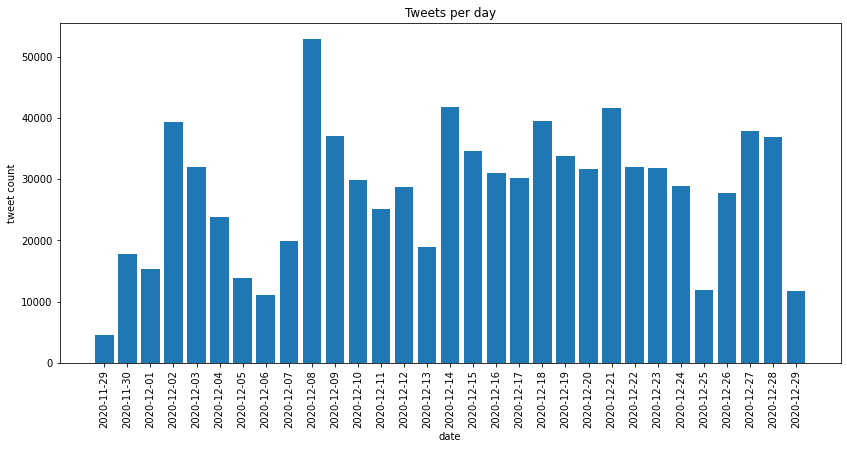

In [32]:
barplot(days, counts, 'Tweets per day', 'date', 'tweet count', 90, (14, 8))

**Top 25 vaccine related hashtags**

In [37]:
from bson.son import SON

pipeline = [
        {'$unwind': "$entities.hashtags" },
        {'$group': {'_id': '$entities.hashtags.text', 'count': {'$sum': 1}}},
        {"$sort": SON([("count", pymongo.DESCENDING)])},
        {'$limit': 25}
    ]

res = tweets.aggregate(pipeline)
for sample in res:
    print(sample)

{'_id': 'vaccine', 'count': 42747}
{'_id': 'COVID19', 'count': 15302}
{'_id': 'Vaccine', 'count': 9458}
{'_id': 'coronavirus', 'count': 3461}
{'_id': 'COVID', 'count': 3160}
{'_id': 'Covid', 'count': 3068}
{'_id': 'Pfizer', 'count': 2682}
{'_id': 'Covid19', 'count': 2489}
{'_id': 'CovidVaccine', 'count': 2459}
{'_id': 'patents', 'count': 1854}
{'_id': 'COVIDー19', 'count': 1818}
{'_id': 'covid19', 'count': 1412}
{'_id': 'AstraZeneca', 'count': 1315}
{'_id': 'vaccination', 'count': 1207}
{'_id': 'covid', 'count': 1167}
{'_id': 'UK', 'count': 1123}
{'_id': 'BillGates', 'count': 962}
{'_id': 'pandemic', 'count': 794}
{'_id': 'Vaccination', 'count': 789}
{'_id': 'cdc', 'count': 783}
{'_id': 'Moderna', 'count': 777}
{'_id': 'vaccines', 'count': 766}
{'_id': 'GatesFoundation', 'count': 736}
{'_id': 'UN', 'count': 721}
{'_id': 'GAVI', 'count': 718}
